### DATASET RESHAPING, DATALOADERS AND maybe Augmentations

In [ ]:
# dataset rehshaping and saving them in our system:

### For one time image reshaping

In [3]:
from PIL import Image
import os
from torchvision.transforms import Resize, InterpolationMode

In [6]:
def preprocess_and_resize(
    original_image_dir,
    original_mask_dir,
    resized_image_dir,
    resized_mask_dir,
    size=(224, 224)
):
    # Define resizing transforms
    resize_img = Resize(size, interpolation=InterpolationMode.BILINEAR)
    resize_mask = Resize(size, interpolation=InterpolationMode.NEAREST)

    # Make sure output directories exist
    os.makedirs(resized_image_dir, exist_ok=True)
    os.makedirs(resized_mask_dir, exist_ok=True)

    for file_name in os.listdir(original_image_dir):
        # Skip files that are not images
        if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(original_image_dir, file_name)
        mask_path = os.path.join(original_mask_dir, os.path.splitext(file_name)[0] + ".png")

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        img_resized = resize_img(img)
        mask_resized = resize_mask(mask)

        img_resized.save(os.path.join(resized_image_dir, file_name))
        mask_resized.save(os.path.join(resized_mask_dir, os.path.splitext(file_name)[0] + ".png"))


In [ ]:
# Get base directory (where this script is located or current working directory)
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    base_dir = os.getcwd()

# Define dataset paths relative to base_dir
data_dir = os.path.join(base_dir, 'data_oxford_iiit')

original_image_dir = os.path.join(data_dir, 'images')
original_mask_dir = os.path.join(data_dir, 'annotations', 'trimaps')

resized_image_dir = os.path.join(data_dir, 'resized_images')
resized_mask_dir = os.path.join(data_dir, 'resized_masks')

# preprocessing function
preprocess_and_resize(
    original_image_dir=original_image_dir,
    original_mask_dir=original_mask_dir,
    resized_image_dir=resized_image_dir,
    resized_mask_dir=resized_mask_dir,
    size=(224, 224)
)

In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def plot_random_images_and_trimaps(image_folder, trimap_folder, num_samples=10):
    """
    Plots random images alongside their corresponding trimaps in a 5x2 grid.

    Args:
        image_folder (str): Path to the folder containing pet images.
        trimap_folder (str): Path to the folder containing trimap masks.
        num_samples (int, optional): Number of random samples to plot. Default is 10.
    """
    image_files = os.listdir(image_folder)
    random_files = random.sample(image_files, num_samples)

    rows = num_samples // 2 + num_samples % 2  # Calculate needed rows for 2 images per row
    fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))  # 2 samples per row, each sample uses 2 subplots

    for i, file_name in enumerate(random_files):
        img_path = os.path.join(image_folder, file_name)
        # Replace extension with .png for trimap
        trimap_file = os.path.splitext(file_name)[0] + ".png"
        trimap_path = os.path.join(trimap_folder, trimap_file)

        img = Image.open(img_path).convert("RGB")
        trimap = Image.open(trimap_path)

        row = i // 2
        col_img = (i % 2) * 2  # 0 or 2 for image
        col_trimap = col_img + 1  # 1 or 3 for trimap

        axes[row, col_img].imshow(img)
        axes[row, col_img].set_title("Image")
        axes[row, col_img].axis('off')

        axes[row, col_trimap].imshow(trimap, cmap='jet')
        axes[row, col_trimap].set_title("Trimap")
        axes[row, col_trimap].axis('off')

    plt.tight_layout()
    plt.show()


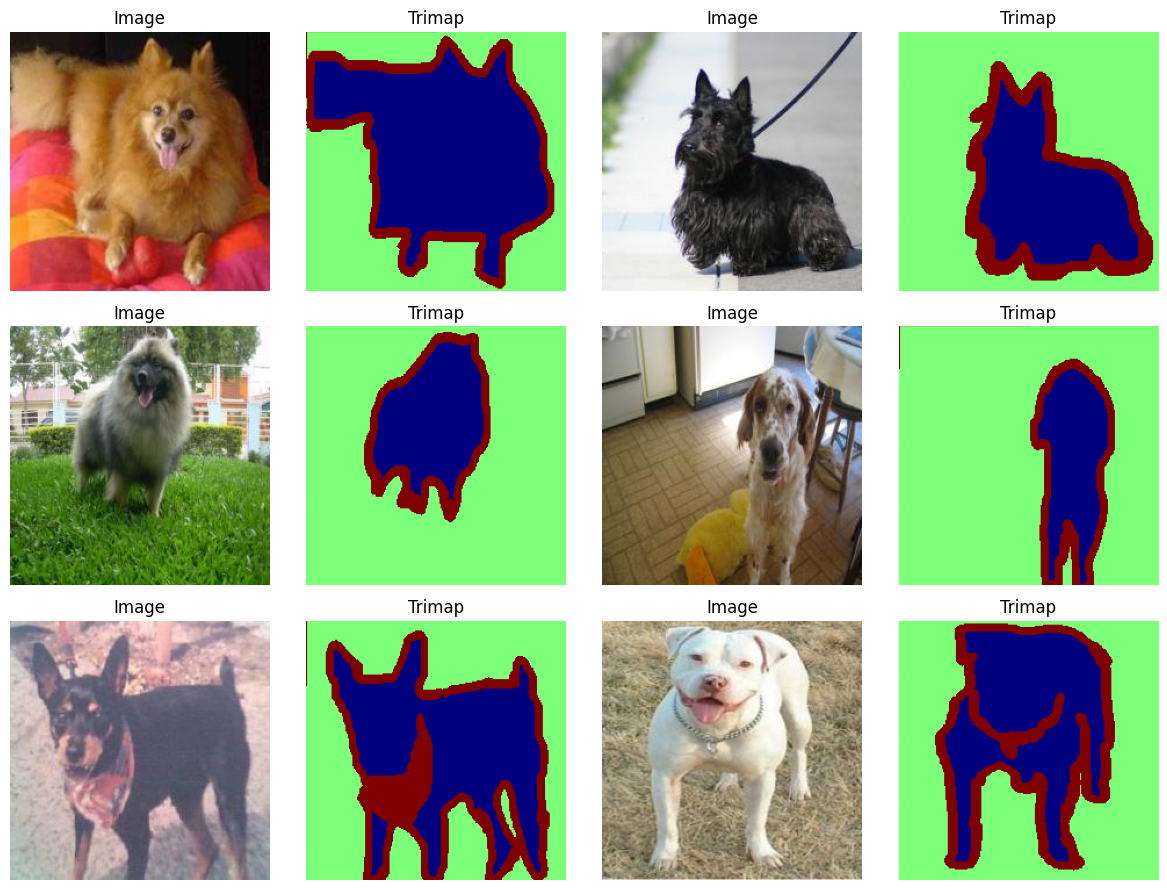

In [4]:
# plotting resized images
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g. in Jupyter notebook or interactive sessions apparently), fallback to cwd
    base_dir = os.getcwd()

# Suppose your dataset is in a folder named 'data' inside the project root:
data_dir = os.path.join(base_dir, 'data_oxford_iiit')

# # Then you can define image and trimap paths relative to that
image_folder = os.path.join(data_dir, 'resized_images')
trimap_folder = os.path.join(data_dir, 'resized_masks')

# plot some images:
plot_random_images_and_trimaps(image_folder, trimap_folder, num_samples=6)

### Simple dataset class

now we do not need any real time transform function, like the code in the cell after the next one:

In [5]:
import os
from PIL import Image
import torch
import torchvision.transforms as T

In [6]:
class PreprocessedPetDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder, image_list):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_list = image_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        file_name = self.image_list[idx]
        img_path = os.path.join(self.image_folder, file_name)
        mask_path = os.path.join(self.mask_folder, os.path.splitext(file_name)[0] + ".png")

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        img_tensor = T.ToTensor()(img)
        img_tensor = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(img_tensor)

        mask_tensor = T.PILToTensor()(mask).long().squeeze()  # squeeze to remove extra channel

        return img_tensor, mask_tensor


In [ ]:
# import torchvision.transforms as T
# from torchvision.transforms.functional import InterpolationMode

# class PetDataset(torch.utils.data.Dataset):
#     def __init__(self, image_folder, trimap_folder, image_list, transform_img=None, transform_mask=None):
#         self.image_folder = image_folder
#         self.trimap_folder = trimap_folder
#         self.image_list = image_list
#         self.transform_img = transform_img
#         self.transform_mask = transform_mask

#     def __len__(self):
#         return len(self.image_list)

#     def __getitem__(self, idx):
#         file_name = self.image_list[idx]
#         img_path = os.path.join(self.image_folder, file_name)
#         trimap_file = os.path.splitext(file_name)[0] + ".png"
#         trimap_path = os.path.join(self.trimap_folder, trimap_file)

#         img = Image.open(img_path).convert("RGB")
#         trimap = Image.open(trimap_path)

#         if self.transform_img:
#             img = self.transform_img(img)
#         if self.transform_mask:
#             trimap = self.transform_mask(trimap)

#         return img, trimap

# # Define your transforms
# transform_img = T.Compose([
#     T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
#     T.ToTensor(),
#     T.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

# transform_mask = T.Compose([
#     T.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
#     T.PILToTensor()  # Or ToTensor() if mask values are [0,1]
# ])


In [ ]:
# and this is how we would create the dataset:
# dataset = PreprocessedPetDataset(resized_img_dir, resized_mask_dir, train_image_list)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


### function to create train, val and test dataloaders

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import random

def get_pet_dataloaders(
    image_folder,
    mask_folder,
    dataset_class,
    val_ratio=0.1,    # Portion for validation
    test_ratio=0.1,   # Portion for testing
    batch_size=16,
    num_workers=4,
    seed=42
    ):
    """
    Creates PyTorch DataLoaders for the Oxford-IIIT Pet dataset with train, validation, and test splits.

    Parameters:
    -----------
    image_folder : str
        Path to the folder containing preprocessed/resized images.
    mask_folder : str
        Path to the folder containing corresponding segmentation masks.
    val_ratio : float, optional (default=0.1)
        Fraction of the dataset to use for validation.
    test_ratio : float, optional (default=0.1)
        Fraction of the dataset to use for testing.
    batch_size : int, optional (default=16)
        Number of samples per batch to load.
    num_workers : int, optional (default=4)
        Number of subprocesses to use for data loading.
    seed : int, optional (default=42)
        Random seed for reproducible shuffling and splitting.

    Returns:
    --------
    train_loader : DataLoader
        DataLoader for the training set with shuffling enabled.
    val_loader : DataLoader
        DataLoader for the validation set without shuffling.
    test_loader : DataLoader
        DataLoader for the test set without shuffling.
    """

    # List all files in the image folder without filtering extensions
    all_files = os.listdir(image_folder)
    all_files.sort()  # Sort to ensure consistent order before shuffling

    # Shuffle the list of filenames using a fixed seed for reproducibility
    random.seed(seed)
    all_files_shuffled = all_files.copy()
    random.shuffle(all_files_shuffled)

    total_size = len(all_files_shuffled)
    test_size = int(total_size * test_ratio)
    val_size = int(total_size * val_ratio)
    train_size = total_size - val_size - test_size

    # Split into train, val, and test lists
    train_files = all_files_shuffled[:train_size] # Training files
    val_files = all_files_shuffled[train_size:train_size + val_size]#val files
    test_files = all_files_shuffled[train_size + val_size:]# Test files

    # Create datasets for each split
    if dataset_class is None:
        raise ValueError("You must provide a dataset_class to use.")

    train_dataset = dataset_class(image_folder, mask_folder, train_files)
    val_dataset = dataset_class(image_folder, mask_folder, val_files)
    test_dataset = dataset_class(image_folder, mask_folder, test_files)

    # Create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [ ]:
# from pet_dataset_class import PreprocessedPetDataset

# train_loader, val_loader, test_loader = get_pet_dataloaders(
#     image_folder="images/",
#     mask_folder="masks/",
#     batch_size=32,
#     dataset_class=PreprocessedPetDataset  
# )

Code for data-augmentation: